In [132]:
import pickle
import pandas as pd
import numpy as np

import re

import matplotlib.pyplot as plt
from scipy.cluster.hierarchy import dendrogram, linkage
from scipy.cluster.hierarchy import fcluster
from sklearn.preprocessing import Normalizer, StandardScaler

from tqdm import tqdm

import spacy
import requests
from scipy.spatial import distance


from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.preprocessing import MaxAbsScaler
from sklearn.preprocessing import StandardScaler
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.svm import SVC

from sklearn.model_selection import GridSearchCV, train_test_split, cross_val_score
from sklearn.metrics import accuracy_score
from sklearn.ensemble import RandomForestClassifier

Because we have a lot of strings in data, sometimes we would like to see full lenght for better examination.

However, this option should be switched off in the analysis. So if you want to change the column size or number of displayed column, use the funcitons below.

See more: https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.set_option.html

In [133]:
# column width
pd.set_option('display.max_colwidth', 50)

# number of columns
pd.set_option('display.max_columns', 0)

# 1. Import of scrapped data

Let's load the data saved in pickle. There are 3 datasets:
1. Links from kuchnialidla.pl
2. links with cousines
3. links with scrapped recipies

Unfortunately, due to website architecture, it was not possible to scrap all data in one loop.

In [134]:
FILE_ALL_TYPE_LINKS     = r'data/all_links_type_pickle.pkl'
FILE_ALL_CUSINE_LINKS   = r'data/all_links_cusine_pickle.pkl'
FILE_ALL_SCRAPPED_PAGES = r'data/pickle_recipe_list.pkl'

with open(FILE_ALL_TYPE_LINKS, mode='rb') as file:
    all_links        = pickle.load(file)
    
with open(FILE_ALL_CUSINE_LINKS, mode='rb') as file:
    all_cusine_links = pickle.load(file)

with open(FILE_ALL_SCRAPPED_PAGES, mode='rb') as file:
    data             = pickle.load(file)

## 1.1. Intro
Quick look on the dataset. How many recipies is available for analysis?

## 1.2. Meal type
Dataset is in dict, so let's make a dataframe.

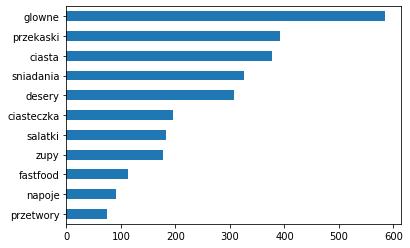

In [135]:
df_all_links         = pd.DataFrame.from_dict(all_links,orient='index')
df_all_links         = df_all_links.T.melt()
df_all_links.columns = ['cusine_category', 'link']
df_all_links.dropna(inplace=True)
df_all_links.drop_duplicates(subset=['link'])
df_all_links         = df_all_links.rename(columns={'cusine_category':'meal_type'})
df_all_links['meal_type'].value_counts()

meal_types_plot      = df_all_links['meal_type'].value_counts()\
                                                .sort_values(ascending=True)\
                                                .plot\
                                                .barh()

We see that sum of all the meal types is much higher than total number of recipies. There are duplicates that need to be examined. We will do that when we merge all the datasets into one.

## 1.3. Cusine style
Now, cusine style. First, let's change the labels.

In [184]:
# keys change
all_cusine_links['amerykanska'] = all_cusine_links.pop('us')
all_cusine_links['azjatycka']   = all_cusine_links.pop('azj')
all_cusine_links['czeska']      = all_cusine_links.pop('cze')
all_cusine_links['francuska']   = all_cusine_links.pop('fra')
all_cusine_links['grecka']      = all_cusine_links.pop('gre')
all_cusine_links['hiszpanska']  = all_cusine_links.pop('esp')
all_cusine_links['polska']      = all_cusine_links.pop('pol')
all_cusine_links['wloska']      = all_cusine_links.pop('ita')
all_cusine_links['brytyjska']   = all_cusine_links.pop('uk')
all_cusine_links['orientalna']  = all_cusine_links.pop('orj')
all_cusine_links['meksykanska'] = all_cusine_links.pop('mex')
all_cusine_links['tajska']      = all_cusine_links.pop('taj')



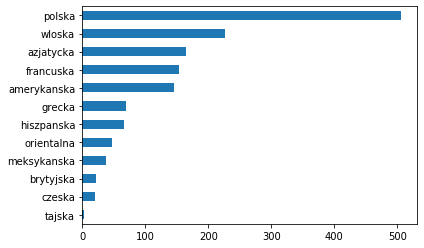

In [185]:
# dict to dataframe
df_all_cusine         = pd.DataFrame.from_dict(all_cusine_links,orient='index')
df_all_cusine         = df_all_cusine.T.melt()
df_all_cusine.columns = ['cusine_style', 'link']
df_all_cusine.dropna(inplace=True)
df_all_cusine         = df_all_cusine.drop_duplicates(subset=['link'])
df_all_cusine.reset_index(inplace=True, drop=True)

cusine_plot = df_all_cusine['cusine_style'].value_counts()\
                                           .sort_values(ascending=True)\
                                           .plot\
                                           .barh()

## 1.4. Recipies
Finally, lets take a look on recipies themselves. First, we need to check if characteristics that we need are available for all reicpies. 

In [137]:
# sprawdzam które przepisy nie miały wpisanych składników
missing_recipies     = {}
missing_ingredients  = []
missing_meal_type    = []
missing_instructions = []
missing_cusine       = []
_trash               = []

for i in range(0,len(data)):
    try:
        _trash.append(data[i][2]['recipeIngredient'])
    except KeyError as a:
        missing_ingredients.append(data[i][2]['name'])

for i in range(0,len(data)):
    try:
        _trash.append(data[i][2]['recipeCategory'])
    except KeyError as a:
        missing_meal_type.append(data[i][2]['name'])
        
for i in range(0,len(data)):
    try:
        _trash.append(data[i][2]['recipeInstructions'])
    except KeyError as a:
        missing_instructions.append(data[i][2]['name'])
        
for i in range(0,len(data)):
    try:
        _trash.append(data[i][2]['recipeCuisine'])
    except KeyError as a:
        missing_cusine.append(data[i][2]['name'])
        
        
missing_recipies['missing_ingredients']  = missing_ingredients
missing_recipies['missing_meal_type']    = missing_meal_type
missing_recipies['missing_instructions'] = missing_instructions
missing_recipies['missing_cusine']       = missing_cusine

        
print(f'Number of missing observations for the given features:\n\n',
       f'- Ingredients: {len(missing_ingredients)}\n', 
       f'- Meal type: {len(missing_meal_type)}\n', 
       f'- Instructions: {len(missing_instructions)}\n', 
       f'- Cusine style: {len(missing_cusine)}\n')

Number of missing observations for the given features:

 - Ingredients: 7
 - Meal type: 0
 - Instructions: 0
 - Cusine style: 1534



As you see, there are a lot of missing data for cusine style. That's why we will use separate dataset (already prepared) to match missing data.

In [138]:
recipes            = []
recipe_with_errors = []
id_number          = 0

for idx,recipe in enumerate(data):
    id_number+=1
    try:
        recipes.append({
#                     'id':id_number,
                    'link'              :data[idx][1],
                    'recipe_name'       :data[idx][2]['name'],
                    'meal_type_detailed':data[idx][2]['recipeCategory'],
                    'ingredients'       :", ".join(data[idx][2]['recipeIngredient']),
                    'instructions'      :data[idx][2]['recipeInstructions']
                   })

    except KeyError as e:
        recipe_with_errors.append(data[idx][2]['name'])
        
df_recipes = pd.DataFrame.from_dict(recipes)
df_recipes 

,link,recipe_name,meal_type_detailed,ingredients,instructions
0,/ravioli-z-cukinia-i-ricotta,Ravioli z cukinią i ricottą,Bez mięsa,"cukinia – 1 szt., oliwa z oliwek – 1 łyżka, cz...",Przygotuj: tarkę o grubych i drobnych oczkach...
1,/galettes-bretonnes-czyli-nalesniki-po-bretonsku,"Galettes bretonnes, czyli naleśniki po bretońsku",Naleśniki na słono,"mąka pszenna – 200 g, mąka gryczana – 100 g, m...",Przygotuj: patelnię do naleśnik&#243;w tarkę ...
2,/kluski-dyniowe-z-jogurtem-i-owocami,Kluski dyniowe z jogurtem i owocami,Kluski,"dynia piżmowa – 1 szt., purée z dyni – 500 g, ...",Przygotuj: piekarnik rozgrzany do temperatury...
3,/kurczak-w-sosie-jogurtowym,Kurczak w sosie jogurtowym,Kurczak,"filet z piersi kurczaka – 400 g, oliwa z oliwe...",Przygotuj: tarkę o drobnych oczkach ręcznik p...
4,/koreanski-dosirak-ryz-z-przystawkami-w-pudelku,Koreański dosirak – ryż z przystawkami w pudełku,Dania z ryżem,"ryż do sushi – 1 szklanka, woda (filtrowana lu...",Przygotuj: pudełko do dosirak l&#243;d w kost...
...,...,...,...,...,...
2792,/banany-smazone-w-ciescie,Banany smażone w cieście,Desery z owocami,"250 ml mleka, 120 g mąki, 1 jajko, 50 g cukru ...","Przygotowanie Mleko, mąkę jajka, cukier puder..."
2793,/serowe-placuszki-z-sosem-malinowym,Serowe placuszki z sosem malinowym,Pancakes,"300 g twarogu półtłustego (do sernika), 3 łyżk...",Przygotowanie Wszystkie składniki starannie z...
2794,/letnie-owoce-pod-kruszonka,Letnie owoce pod kruszonką,Desery z owocami,"płatki owsiane Nordwaldtaler: 0,75 szklanki, m...",Przygotowanie Płatki i ziarno słonecznika pra...
2795,/kawa-z-lodami-i-bita-smietana,Kawa z lodami i bitą śmietaną,Kawa,krem czekoladowy Mister Choc lub rozpuszczona ...,Na jedną szklankę Na dno wysokiej szklanki wk...


In our analysis we will use ingredients and instructions as a benchmark. Therefore, we need to check how the list of ingredients looks, so we can use the right method to extract ingredients names. 

Yet we see that in the instructions we have some letters and characters like "ó" marked as "&#243;" which were not recognized correctly. But since instructions are not key data for analysis, I will leave it as it is for now. We will work on that if necessary later.

Now, let's focus on ingredients. How they look? (rand a few items)

In [139]:
rand = df_recipes['ingredients'].sample(n=1)
pprint(rand)

1929    mielone siemię lniane – 3 łyżki, gorąca woda –...
Name: ingredients, dtype: object


What all of them have in common is comma ingredient separation. Unfortunately, as you see, apart from that, they are written with no clear pattern. There are numbers, special characters, additional words, measurement units and polish forms. 

In great majority measurements are at the end of the phrase, separated by "-":

In [140]:
example1 = [i for i in df_recipes['ingredients'].iloc[2406].split(", ")]
pprint(example1)

['mąka pszenna – 175 g',
 'orzechy laskowe – 75 g',
 'proszek do pieczenia – 1 łyżeczka',
 'masło – 125 g',
 'cukier – 125 g',
 'sól',
 'jaja – 2 szt.',
 'mleko – 50 ml',
 'czekolada biała – 200 g',
 'czekolada deserowa – 30 g']


But in some recipies, they are at front with no special character separation.

In [141]:
example2 = [i for i in df_recipes['ingredients'].iloc[2173].split(", ")]
pprint(example2)

['5 jajek',
 'umytych',
 'rozmiar L',
 'białka oddzielone od żółtek',
 '120g cukru',
 '110 g mąki pszennej',
 '20 g mączki ziemniaczanej',
 '1 płaska łyżeczka proszku do pieczenia',
 '1/2 łyżeczki sody',
 '50 g kakao',
 '40 ml oleju',
 '3 łyżki wody',
 '60 g cukru',
 '60 ml wody',
 '1 opakowanie cukru wanilinowego',
 '50 ml wódki (opcjonalnie)',
 '120g cukru',
 '80 ml wody',
 'gorącej',
 '200 g orzeszków arachidowych solonych',
 '400 g masła',
 'miękkiego',
 '110 g cukru pudru',
 '454 g masła orzechowego (z orzechów ziemnych o temperaturze pokojowej)']


Since we have over 2000 recipies, we are not able to examin all of them to find any easy rule to extract only product names that we need. Therefore, we will start simple. 

In [142]:
instructions              = []
recipe_names              = []
dataset                   = []
meal_type                 = []
links                     = []
ingredients_raw           = []
ingredients_initial_clean = []
meal_type_detailed        = []
ingredients_count         = []

for idx,recipe_list in enumerate(recipes):
    recipe_names.append(recipes[idx]['recipe_name'])
    links.append(recipes[idx]['link'])    
    ingredients_raw.append(recipes[idx]['ingredients'])
    instructions.append(recipes[idx]['instructions'])
    meal_type_detailed.append(recipes[idx]['meal_type_detailed'])
    
#     first we need to split each ingredient group by comma
    ingredients_regex_cleaned = recipes[idx]['ingredients']
    ingredients_regex_cleaned = ingredients_regex_cleaned.split(", ")
    
# return how many ingredients are needed for recipe
    ingredients_count.append(len(ingredients_regex_cleaned))

#     then, take only first part if there is "-" in the group
    ingredients_regex_cleaned = [re.split('–|:',i)[0].strip(' ') for i in ingredients_regex_cleaned]
    ingredients_regex_cleaned = str(", ".join(ingredients_regex_cleaned))

#     now we get rid of the numbers if they are at the beginning of the ingredient group
    ingredients_regex_cleaned = re.sub(r"(\d+[,-])?(\d*)|%", "", ingredients_regex_cleaned)

    ingredients_initial_clean.append(ingredients_regex_cleaned)

    
data_dict                         = {}
data_dict["link"]                 = links
# data_dict["recipe_name"]        = recipe_names
data_dict["raw_ingredients"]      = ingredients_raw
data_dict["cleaned_ingredients"]  = ingredients_initial_clean
data_dict["ingredients_count"]    = ingredients_count
# data_dict["meal_type_detailed"] = meal_type_detailed
# data_dict["instructions"]       = instructions


df_data_dict = pd.DataFrame(data_dict)
df_data_dict

,link,raw_ingredients,cleaned_ingredients,ingredients_count
0,/ravioli-z-cukinia-i-ricotta,"cukinia – 1 szt., oliwa z oliwek – 1 łyżka, cz...","cukinia, oliwa z oliwek, czosnek, świeża bazyl...",22
1,/galettes-bretonnes-czyli-nalesniki-po-bretonsku,"mąka pszenna – 200 g, mąka gryczana – 100 g, m...","mąka pszenna, mąka gryczana, mleko, jajka, wod...",12
2,/kluski-dyniowe-z-jogurtem-i-owocami,"dynia piżmowa – 1 szt., purée z dyni – 500 g, ...","dynia piżmowa, purée z dyni, mąka pszenna, mąk...",17
3,/kurczak-w-sosie-jogurtowym,"filet z piersi kurczaka – 400 g, oliwa z oliwe...","filet z piersi kurczaka, oliwa z oliwek, masło...",16
4,/koreanski-dosirak-ryz-z-przystawkami-w-pudelku,"ryż do sushi – 1 szklanka, woda (filtrowana lu...","ryż do sushi, woda (filtrowana lub niskozminer...",24
...,...,...,...,...
2792,/banany-smazone-w-ciescie,"250 ml mleka, 120 g mąki, 1 jajko, 50 g cukru ...","ml mleka, g mąki, jajko, g cukru pudru, g...",7
2793,/serowe-placuszki-z-sosem-malinowym,"300 g twarogu półtłustego (do sernika), 3 łyżk...","g twarogu półtłustego (do sernika), łyżki mą...",11
2794,/letnie-owoce-pod-kruszonka,"płatki owsiane Nordwaldtaler: 0,75 szklanki, m...","płatki owsiane Nordwaldtaler, masło Pilos do k...",12
2795,/kawa-z-lodami-i-bita-smietana,krem czekoladowy Mister Choc lub rozpuszczona ...,krem czekoladowy Mister Choc lub rozpuszczona ...,4


# 2. Dataset preparation

## 2.1. Datasets merge

In [143]:
# join scrapped recipies with recipe data
df_working = pd.merge(df_recipes, df_all_links, on='link')
df_working = pd.merge(df_working, df_data_dict, on='link', how='inner')

# join new dataframe with cusine styles
df_working = pd.merge(df_working, df_all_cusine, on='link', how='left')

# remove duplicates
df_working = df_working.drop_duplicates()

# reset index
df_working.reset_index(drop=True, inplace=True)
df_working

,link,recipe_name,meal_type_detailed,ingredients,instructions,meal_type,raw_ingredients,cleaned_ingredients,ingredients_count,cusine_style
0,/ravioli-z-cukinia-i-ricotta,Ravioli z cukinią i ricottą,Bez mięsa,"cukinia – 1 szt., oliwa z oliwek – 1 łyżka, cz...",Przygotuj: tarkę o grubych i drobnych oczkach...,glowne,"cukinia – 1 szt., oliwa z oliwek – 1 łyżka, cz...","cukinia, oliwa z oliwek, czosnek, świeża bazyl...",22,wloska
1,/galettes-bretonnes-czyli-nalesniki-po-bretonsku,"Galettes bretonnes, czyli naleśniki po bretońsku",Naleśniki na słono,"mąka pszenna – 200 g, mąka gryczana – 100 g, m...",Przygotuj: patelnię do naleśnik&#243;w tarkę ...,glowne,"mąka pszenna – 200 g, mąka gryczana – 100 g, m...","mąka pszenna, mąka gryczana, mleko, jajka, wod...",12,francuska
2,/galettes-bretonnes-czyli-nalesniki-po-bretonsku,"Galettes bretonnes, czyli naleśniki po bretońsku",Naleśniki na słono,"mąka pszenna – 200 g, mąka gryczana – 100 g, m...",Przygotuj: patelnię do naleśnik&#243;w tarkę ...,sniadania,"mąka pszenna – 200 g, mąka gryczana – 100 g, m...","mąka pszenna, mąka gryczana, mleko, jajka, wod...",12,francuska
3,/kluski-dyniowe-z-jogurtem-i-owocami,Kluski dyniowe z jogurtem i owocami,Kluski,"dynia piżmowa – 1 szt., purée z dyni – 500 g, ...",Przygotuj: piekarnik rozgrzany do temperatury...,glowne,"dynia piżmowa – 1 szt., purée z dyni – 500 g, ...","dynia piżmowa, purée z dyni, mąka pszenna, mąk...",17,polska
4,/kurczak-w-sosie-jogurtowym,Kurczak w sosie jogurtowym,Kurczak,"filet z piersi kurczaka – 400 g, oliwa z oliwe...",Przygotuj: tarkę o drobnych oczkach ręcznik p...,glowne,"filet z piersi kurczaka – 400 g, oliwa z oliwe...","filet z piersi kurczaka, oliwa z oliwek, masło...",16,NaN
...,...,...,...,...,...,...,...,...,...,...
2785,/mus-czekoladowy-z-malinami,Mus czekoladowy z malinami,Desery czekoladowe,"100 g świeżych lub mrożonych malin, 15 g cukru...",Przygotowanie Żelatynę moczymy w zimnej wodzi...,desery,"100 g świeżych lub mrożonych malin, 15 g cukru...","g świeżych lub mrożonych malin, g cukru pudr...",8,NaN
2786,/jablka-zapiekane-z-zurawina,Jabłka zapiekane z żurawiną,Desery z owocami,"50 g białek jaj (2 białka jaj), 70 g cukru, 30...",Masa bezowa Białka ubijamy na sztywną masę. D...,desery,"50 g białek jaj (2 białka jaj), 70 g cukru, 30...","g białek jaj ( białka jaj), g cukru, g migd...",5,NaN
2787,/panna-cotta-waniliowa-z-owocami-lasu,Panna cotta waniliowa z owocami lasu,Desery z owocami,"250 ml śmietanki 30%, 250 ml mleka 3,2%, 80-10...","Przygotowanie Mleko, śmietankę i cukier podgr...",desery,"250 ml śmietanki 30%, 250 ml mleka 3,2%, 80-10...","ml śmietanki , ml mleka , g cukru kryształu...",11,wloska
2788,/letnie-owoce-pod-kruszonka,Letnie owoce pod kruszonką,Desery z owocami,"płatki owsiane Nordwaldtaler: 0,75 szklanki, m...",Przygotowanie Płatki i ziarno słonecznika pra...,desery,"płatki owsiane Nordwaldtaler: 0,75 szklanki, m...","płatki owsiane Nordwaldtaler, masło Pilos do k...",12,NaN


### 2.1.1. Save prepared dataframe

This is our working database, let's save it for later use. 

In [144]:
# df_working.to_pickle("data/df_working_pickle.pkl")

df_working = pd.read_pickle("data/df_working_pickle.pkl")
df_working

,link,recipe_name,meal_type_detailed,ingredients,instructions,meal_type,raw_ingredients,cleaned_ingredients,ingredients_count,cusine_style
0,/ravioli-z-cukinia-i-ricotta,Ravioli z cukinią i ricottą,Bez mięsa,"cukinia – 1 szt., oliwa z oliwek – 1 łyżka, cz...",Przygotuj: tarkę o grubych i drobnych oczkach...,glowne,"cukinia – 1 szt., oliwa z oliwek – 1 łyżka, cz...","cukinia, oliwa z oliwek, czosnek, świeża bazyl...",22,wloska
1,/galettes-bretonnes-czyli-nalesniki-po-bretonsku,"Galettes bretonnes, czyli naleśniki po bretońsku",Naleśniki na słono,"mąka pszenna – 200 g, mąka gryczana – 100 g, m...",Przygotuj: patelnię do naleśnik&#243;w tarkę ...,glowne,"mąka pszenna – 200 g, mąka gryczana – 100 g, m...","mąka pszenna, mąka gryczana, mleko, jajka, wod...",12,francuska
2,/galettes-bretonnes-czyli-nalesniki-po-bretonsku,"Galettes bretonnes, czyli naleśniki po bretońsku",Naleśniki na słono,"mąka pszenna – 200 g, mąka gryczana – 100 g, m...",Przygotuj: patelnię do naleśnik&#243;w tarkę ...,sniadania,"mąka pszenna – 200 g, mąka gryczana – 100 g, m...","mąka pszenna, mąka gryczana, mleko, jajka, wod...",12,francuska
3,/kluski-dyniowe-z-jogurtem-i-owocami,Kluski dyniowe z jogurtem i owocami,Kluski,"dynia piżmowa – 1 szt., purée z dyni – 500 g, ...",Przygotuj: piekarnik rozgrzany do temperatury...,glowne,"dynia piżmowa – 1 szt., purée z dyni – 500 g, ...","dynia piżmowa, purée z dyni, mąka pszenna, mąk...",17,polska
4,/kurczak-w-sosie-jogurtowym,Kurczak w sosie jogurtowym,Kurczak,"filet z piersi kurczaka – 400 g, oliwa z oliwe...",Przygotuj: tarkę o drobnych oczkach ręcznik p...,glowne,"filet z piersi kurczaka – 400 g, oliwa z oliwe...","filet z piersi kurczaka, oliwa z oliwek, masło...",16,NaN
...,...,...,...,...,...,...,...,...,...,...
2785,/mus-czekoladowy-z-malinami,Mus czekoladowy z malinami,Desery czekoladowe,"100 g świeżych lub mrożonych malin, 15 g cukru...",Przygotowanie Żelatynę moczymy w zimnej wodzi...,desery,"100 g świeżych lub mrożonych malin, 15 g cukru...","g świeżych lub mrożonych malin, g cukru pudr...",8,NaN
2786,/jablka-zapiekane-z-zurawina,Jabłka zapiekane z żurawiną,Desery z owocami,"50 g białek jaj (2 białka jaj), 70 g cukru, 30...",Masa bezowa Białka ubijamy na sztywną masę. D...,desery,"50 g białek jaj (2 białka jaj), 70 g cukru, 30...","g białek jaj ( białka jaj), g cukru, g migd...",5,NaN
2787,/panna-cotta-waniliowa-z-owocami-lasu,Panna cotta waniliowa z owocami lasu,Desery z owocami,"250 ml śmietanki 30%, 250 ml mleka 3,2%, 80-10...","Przygotowanie Mleko, śmietankę i cukier podgr...",desery,"250 ml śmietanki 30%, 250 ml mleka 3,2%, 80-10...","ml śmietanki , ml mleka , g cukru kryształu...",11,wloska
2788,/letnie-owoce-pod-kruszonka,Letnie owoce pod kruszonką,Desery z owocami,"płatki owsiane Nordwaldtaler: 0,75 szklanki, m...",Przygotowanie Płatki i ziarno słonecznika pra...,desery,"płatki owsiane Nordwaldtaler: 0,75 szklanki, m...","płatki owsiane Nordwaldtaler, masło Pilos do k...",12,NaN


## 2.2 Final cleaning

Recipies are assigned to more than 1 meal type
W trakcie przeglądania bazy, da się zaobserwowć, że niektóre przepisy są przypasowane do więcej niż jednej kategorii. Na przykładzie poniżej widać, że Chutney jabłkowy jest zaklasyfikowany do przetworów i przekąsek

In [145]:
df_working[df_working['link']=='/3-sposoby-na-chutney-jablkowy']

,link,recipe_name,meal_type_detailed,ingredients,instructions,meal_type,raw_ingredients,cleaned_ingredients,ingredients_count,cusine_style
1248,/3-sposoby-na-chutney-jablkowy,3 sposoby na chutney jabłkowy,Przetwory owocowe,"jabłka – 2 szt., cukier – 200 g, biały ocet wi...",Przygotuj słoiczki Chutney z kolendrą W garnk...,przetwory,"jabłka – 2 szt., cukier – 200 g, biały ocet wi...","jabłka, cukier, biały ocet winny, kolendra w z...",19,azjatycka
1249,/3-sposoby-na-chutney-jablkowy,3 sposoby na chutney jabłkowy,Przetwory owocowe,"jabłka – 2 szt., cukier – 200 g, biały ocet wi...",Przygotuj słoiczki Chutney z kolendrą W garnk...,przekaski,"jabłka – 2 szt., cukier – 200 g, biały ocet wi...","jabłka, cukier, biały ocet winny, kolendra w z...",19,azjatycka


In [146]:
pd.concat(i for _, i in df_working.groupby("recipe_name") if len(i) > 1)

,link,recipe_name,meal_type_detailed,ingredients,instructions,meal_type,raw_ingredients,cleaned_ingredients,ingredients_count,cusine_style
2468,/2-sposoby-na-batony-po-treningu,2 sposoby na batony po treningu,Ciasteczka owsiane,"płatki owsiane – 1,5 szklanki, kasza jaglana e...",Przygotuj 2 blachy o wymiarach 15 x 15 cm mik...,ciasteczka,"płatki owsiane – 1,5 szklanki, kasza jaglana e...","płatki owsiane, kasza jaglana ekspandowana, ma...",16,NaN
2469,/2-sposoby-na-batony-po-treningu,2 sposoby na batony po treningu,Ciasteczka owsiane,"płatki owsiane – 1,5 szklanki, kasza jaglana e...",Przygotuj 2 blachy o wymiarach 15 x 15 cm mik...,desery,"płatki owsiane – 1,5 szklanki, kasza jaglana e...","płatki owsiane, kasza jaglana ekspandowana, ma...",16,NaN
623,/2-sposoby-na-pizze-z-brokulu-i-kalafiora,2 sposoby na pizzę - z brokułu i kalafiora,Dania z warzyw,"kalafior – 0,5 główki, czosnek – 1 ząbek, ser ...",Pizza na spodzie z kalafiora Przygotuj piekar...,glowne,"kalafior – 0,5 główki, czosnek – 1 ząbek, ser ...","kalafior, czosnek, ser mozzarella light, jajko...",32,NaN
624,/2-sposoby-na-pizze-z-brokulu-i-kalafiora,2 sposoby na pizzę - z brokułu i kalafiora,Dania z warzyw,"kalafior – 0,5 główki, czosnek – 1 ząbek, ser ...",Pizza na spodzie z kalafiora Przygotuj piekar...,fastfood,"kalafior – 0,5 główki, czosnek – 1 ząbek, ser ...","kalafior, czosnek, ser mozzarella light, jajko...",32,NaN
625,/3-dania-fit-sniadanie-obiad-deser,"3 dania fit! Śniadanie, obiad, deser",Makaron z pesto,"chleb razowy – 2 kromki, awokado – 1 szt., pom...",Tosty z awokado Krok 1: Podpiekamy kromki chl...,glowne,"chleb razowy – 2 kromki, awokado – 1 szt., pom...","chleb razowy, awokado, pomidor, jaja, parmezan...",34,NaN
...,...,...,...,...,...,...,...,...,...,...
457,/sniadaniowe-burrito,Śniadaniowe burrito,Dania mięsne,"śmietana 18% – 150 g, pieprz cayenne, limonka ...",Krok 1: Przygotowujemy sos Śmietanę mieszamy ...,fastfood,"śmietana 18% – 150 g, pieprz cayenne, limonka ...","śmietana , pieprz cayenne, limonka, miód, kieł...",11,meksykanska
1392,/sniadaniowy-chlebek-marchewkowy,Śniadaniowy chlebek marchewkowy,Pieczywo,"marchewka – 2 szt., olej – 2 łyżki, suszone dr...","PRZYGOTUJ tarkę o grubych oczkach, robot kuch...",sniadania,"marchewka – 2 szt., olej – 2 łyżki, suszone dr...","marchewka, olej, suszone drożdże instant, ciep...",13,NaN
1393,/sniadaniowy-chlebek-marchewkowy,Śniadaniowy chlebek marchewkowy,Pieczywo,"marchewka – 2 szt., olej – 2 łyżki, suszone dr...","PRZYGOTUJ tarkę o grubych oczkach, robot kuch...",przekaski,"marchewka – 2 szt., olej – 2 łyżki, suszone dr...","marchewka, olej, suszone drożdże instant, ciep...",13,NaN
1741,/swiateczny-pasztet-z-pistacjami-i-zurawina,Świąteczny pasztet z pistacjami i żurawiną,Śniadania,"80 dag mięsa z udek kurczaka, 20 dag piersi ku...","Przygotowanie Mięso drobiowe myjemy, zalewamy...",sniadania,"80 dag mięsa z udek kurczaka, 20 dag piersi ku...","dag mięsa z udek kurczaka, dag piersi kurcza...",19,polska


In [147]:
pd.concat(i for _, i in df_working.groupby("recipe_name") if len(i) > 1)

,link,recipe_name,meal_type_detailed,ingredients,instructions,meal_type,raw_ingredients,cleaned_ingredients,ingredients_count,cusine_style
2468,/2-sposoby-na-batony-po-treningu,2 sposoby na batony po treningu,Ciasteczka owsiane,"płatki owsiane – 1,5 szklanki, kasza jaglana e...",Przygotuj 2 blachy o wymiarach 15 x 15 cm mik...,ciasteczka,"płatki owsiane – 1,5 szklanki, kasza jaglana e...","płatki owsiane, kasza jaglana ekspandowana, ma...",16,NaN
2469,/2-sposoby-na-batony-po-treningu,2 sposoby na batony po treningu,Ciasteczka owsiane,"płatki owsiane – 1,5 szklanki, kasza jaglana e...",Przygotuj 2 blachy o wymiarach 15 x 15 cm mik...,desery,"płatki owsiane – 1,5 szklanki, kasza jaglana e...","płatki owsiane, kasza jaglana ekspandowana, ma...",16,NaN
623,/2-sposoby-na-pizze-z-brokulu-i-kalafiora,2 sposoby na pizzę - z brokułu i kalafiora,Dania z warzyw,"kalafior – 0,5 główki, czosnek – 1 ząbek, ser ...",Pizza na spodzie z kalafiora Przygotuj piekar...,glowne,"kalafior – 0,5 główki, czosnek – 1 ząbek, ser ...","kalafior, czosnek, ser mozzarella light, jajko...",32,NaN
624,/2-sposoby-na-pizze-z-brokulu-i-kalafiora,2 sposoby na pizzę - z brokułu i kalafiora,Dania z warzyw,"kalafior – 0,5 główki, czosnek – 1 ząbek, ser ...",Pizza na spodzie z kalafiora Przygotuj piekar...,fastfood,"kalafior – 0,5 główki, czosnek – 1 ząbek, ser ...","kalafior, czosnek, ser mozzarella light, jajko...",32,NaN
625,/3-dania-fit-sniadanie-obiad-deser,"3 dania fit! Śniadanie, obiad, deser",Makaron z pesto,"chleb razowy – 2 kromki, awokado – 1 szt., pom...",Tosty z awokado Krok 1: Podpiekamy kromki chl...,glowne,"chleb razowy – 2 kromki, awokado – 1 szt., pom...","chleb razowy, awokado, pomidor, jaja, parmezan...",34,NaN
...,...,...,...,...,...,...,...,...,...,...
457,/sniadaniowe-burrito,Śniadaniowe burrito,Dania mięsne,"śmietana 18% – 150 g, pieprz cayenne, limonka ...",Krok 1: Przygotowujemy sos Śmietanę mieszamy ...,fastfood,"śmietana 18% – 150 g, pieprz cayenne, limonka ...","śmietana , pieprz cayenne, limonka, miód, kieł...",11,meksykanska
1392,/sniadaniowy-chlebek-marchewkowy,Śniadaniowy chlebek marchewkowy,Pieczywo,"marchewka – 2 szt., olej – 2 łyżki, suszone dr...","PRZYGOTUJ tarkę o grubych oczkach, robot kuch...",sniadania,"marchewka – 2 szt., olej – 2 łyżki, suszone dr...","marchewka, olej, suszone drożdże instant, ciep...",13,NaN
1393,/sniadaniowy-chlebek-marchewkowy,Śniadaniowy chlebek marchewkowy,Pieczywo,"marchewka – 2 szt., olej – 2 łyżki, suszone dr...","PRZYGOTUJ tarkę o grubych oczkach, robot kuch...",przekaski,"marchewka – 2 szt., olej – 2 łyżki, suszone dr...","marchewka, olej, suszone drożdże instant, ciep...",13,NaN
1741,/swiateczny-pasztet-z-pistacjami-i-zurawina,Świąteczny pasztet z pistacjami i żurawiną,Śniadania,"80 dag mięsa z udek kurczaka, 20 dag piersi ku...","Przygotowanie Mięso drobiowe myjemy, zalewamy...",sniadania,"80 dag mięsa z udek kurczaka, 20 dag piersi ku...","dag mięsa z udek kurczaka, dag piersi kurcza...",19,polska


Grupuję linki, żeby sprawdzić, które przepisy mają więcej niż jedną kategorię posiłku

In [200]:
duplicated_categories = df_working.groupby(by = ['link']).count()
duplicated_categories = duplicated_categories[duplicated_categories['recipe_name']>1]

print(f'{len(duplicated_categories)} recipes belongs to more than 1 meal type')

455 recipes belongs to more than 1 meal type


### 2.2.1 Drop duplicates
Since meal type will not be used in our analysis, we will drop it and keep only one (keep first). It's a cost that we can afford at this point. If later on we need data an all meal types, we can load a pickle. But first we need to create and save them.

In [212]:
df_working_duplicates = df_working
df_working            = df_working.drop_duplicates(subset=['link'])

df_working_duplicates.to_pickle("data/df_working_duplicates.pkl")


Just if we need the training and test sets, we will save partitions with and without duplicates as well.

In [213]:
df_working_no_recipes_with_more_types = df_working[~df_working['link'].isin(duplicated_categories.index)]

In [214]:
df_working_recipes_with_more_types = df_working[df_working['link'].isin(duplicated_categories.index)]

### 2.2.2. Cusine style
There is significant number of missing data in cusine style. If we were doing cusine style classification, that would be a good test set. Maybe we will do such analysis later on.

In [215]:
df_working.isnull().sum()

link                      0
recipe_name               0
meal_type_detailed        0
ingredients               0
instructions              0
meal_type                 0
raw_ingredients           0
cleaned_ingredients       0
ingredients_count         0
cusine_style           1233
dtype: int64

### 2.2.3. Number of ingredients
For sure there are some outlier that will spoil our analysis. Both too many ingredients and not too many are problematic. Let's see the histogram.

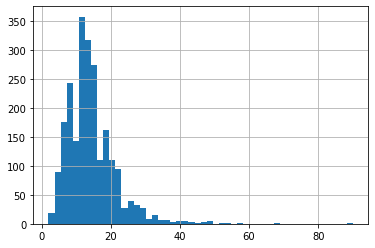

In [216]:
df_working['ingredients_count'].hist(bins=50)

There is very long tail of observation above the 30. As a rule of thumb we will remove all recipes with more than 30 ingredients.

In [217]:
diff = df_working.shape[0] - df_working.loc[df_working['ingredients_count'] <= 30].shape[0]
print(f'There are {diff} recipes with more than 30 ingredients')

There are 67 recipes with more than 30 ingredients


Fair enough, lets remove them. Histogram looks much better.

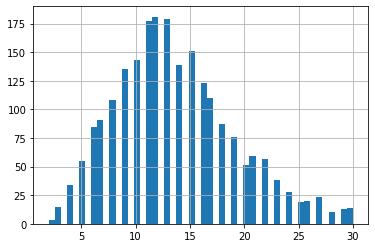

In [218]:
df_working = df_working.loc[df_working['ingredients_count'] <= 30]
df_working['ingredients_count'].hist(bins=50)

Ok, how our changes impacted the meal type and cusine style?

The highest changes in recipe numbers are in sniadania, desery and zupy.

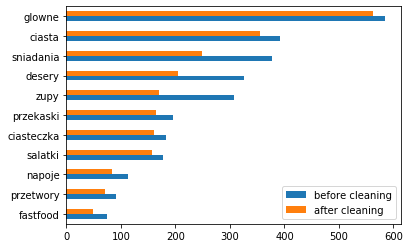

In [219]:
df_type_plot = pd.DataFrame({'before cleaning': df_all_links['meal_type'].value_counts().sort_values(ascending=True).values,
                    'after cleaning': df_working['meal_type'].value_counts().sort_values(ascending=True).values}, index=df_working['meal_type'].value_counts().sort_values(ascending=True).index)
ax = df_type_plot.plot.barh()


Proportion of losses are approximately same for majority of cusine styles, except tajska, czeska, brytyjska and grecka. 

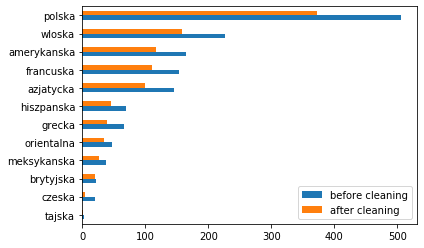

In [220]:
df_cusine_plot = pd.DataFrame({'before cleaning': df_all_cusine['cusine_style']\
                               .value_counts()\
                               .sort_values(ascending=True)\
                               .values,
                                'after cleaning': df_working['cusine_style']\
                               .value_counts()\
                               .sort_values(ascending=True)\
                               .values}, 
                                index=df_working['cusine_style']\
                               .value_counts().sort_values(ascending=True).index)
ax = df_cusine_plot.plot.barh()


In [221]:
list(zip((df_all_cusine['cusine_style'].value_counts().sort_values(ascending=True).values \
         / df_working['cusine_style'].value_counts().sort_values(ascending=True).values - 1),\
         df_working['cusine_style'].value_counts().sort_values(ascending=True).index))

[(0.5, 'tajska'),
 (3.0, 'czeska'),
 (0.10000000000000009, 'brytyjska'),
 (0.37037037037037046, 'meksykanska'),
 (0.34285714285714275, 'orientalna'),
 (0.6499999999999999, 'grecka'),
 (0.5333333333333334, 'hiszpanska'),
 (0.4747474747474747, 'azjatycka'),
 (0.3873873873873874, 'francuska'),
 (0.41025641025641035, 'amerykanska'),
 (0.4303797468354431, 'wloska'),
 (0.35656836461126007, 'polska')]

Dataframe is ready for the next stage, to let's save it.

In [228]:
df_working.to_pickle("data/df_working_pickle.pkl")
df_working

,link,recipe_name,meal_type_detailed,ingredients,instructions,meal_type,raw_ingredients,cleaned_ingredients,ingredients_count,cusine_style
0,/ravioli-z-cukinia-i-ricotta,Ravioli z cukinią i ricottą,Bez mięsa,"cukinia – 1 szt., oliwa z oliwek – 1 łyżka, cz...",Przygotuj: tarkę o grubych i drobnych oczkach...,glowne,"cukinia – 1 szt., oliwa z oliwek – 1 łyżka, cz...","cukinia, oliwa z oliwek, czosnek, świeża bazyl...",22,wloska
1,/galettes-bretonnes-czyli-nalesniki-po-bretonsku,"Galettes bretonnes, czyli naleśniki po bretońsku",Naleśniki na słono,"mąka pszenna – 200 g, mąka gryczana – 100 g, m...",Przygotuj: patelnię do naleśnik&#243;w tarkę ...,glowne,"mąka pszenna – 200 g, mąka gryczana – 100 g, m...","mąka pszenna, mąka gryczana, mleko, jajka, wod...",12,francuska
3,/kluski-dyniowe-z-jogurtem-i-owocami,Kluski dyniowe z jogurtem i owocami,Kluski,"dynia piżmowa – 1 szt., purée z dyni – 500 g, ...",Przygotuj: piekarnik rozgrzany do temperatury...,glowne,"dynia piżmowa – 1 szt., purée z dyni – 500 g, ...","dynia piżmowa, purée z dyni, mąka pszenna, mąk...",17,polska
4,/kurczak-w-sosie-jogurtowym,Kurczak w sosie jogurtowym,Kurczak,"filet z piersi kurczaka – 400 g, oliwa z oliwe...",Przygotuj: tarkę o drobnych oczkach ręcznik p...,glowne,"filet z piersi kurczaka – 400 g, oliwa z oliwe...","filet z piersi kurczaka, oliwa z oliwek, masło...",16,NaN
5,/koreanski-dosirak-ryz-z-przystawkami-w-pudelku,Koreański dosirak – ryż z przystawkami w pudełku,Dania z ryżem,"ryż do sushi – 1 szklanka, woda (filtrowana lu...",Przygotuj: pudełko do dosirak l&#243;d w kost...,glowne,"ryż do sushi – 1 szklanka, woda (filtrowana lu...","ryż do sushi, woda (filtrowana lub niskozminer...",24,azjatycka
...,...,...,...,...,...,...,...,...,...,...
2785,/mus-czekoladowy-z-malinami,Mus czekoladowy z malinami,Desery czekoladowe,"100 g świeżych lub mrożonych malin, 15 g cukru...",Przygotowanie Żelatynę moczymy w zimnej wodzi...,desery,"100 g świeżych lub mrożonych malin, 15 g cukru...","g świeżych lub mrożonych malin, g cukru pudr...",8,NaN
2786,/jablka-zapiekane-z-zurawina,Jabłka zapiekane z żurawiną,Desery z owocami,"50 g białek jaj (2 białka jaj), 70 g cukru, 30...",Masa bezowa Białka ubijamy na sztywną masę. D...,desery,"50 g białek jaj (2 białka jaj), 70 g cukru, 30...","g białek jaj ( białka jaj), g cukru, g migd...",5,NaN
2787,/panna-cotta-waniliowa-z-owocami-lasu,Panna cotta waniliowa z owocami lasu,Desery z owocami,"250 ml śmietanki 30%, 250 ml mleka 3,2%, 80-10...","Przygotowanie Mleko, śmietankę i cukier podgr...",desery,"250 ml śmietanki 30%, 250 ml mleka 3,2%, 80-10...","ml śmietanki , ml mleka , g cukru kryształu...",11,wloska
2788,/letnie-owoce-pod-kruszonka,Letnie owoce pod kruszonką,Desery z owocami,"płatki owsiane Nordwaldtaler: 0,75 szklanki, m...",Przygotowanie Płatki i ziarno słonecznika pra...,desery,"płatki owsiane Nordwaldtaler: 0,75 szklanki, m...","płatki owsiane Nordwaldtaler, masło Pilos do k...",12,NaN


In [231]:
print(f'In the final dataset there are {df_working.shape[0]} unique recipes')

In the final dataset there are 2224 unique recipes


# 3. Dataset preparation summary
In the dataset, there is overrepresentation of polish cusine and sweet dishes (ciasta, ciasteczka, desery). However, it should not be an issue, since this is dataset for exploration. Additionally, the meal type segmentation itself might change if we take time and make proper classification for the recipes with more than one type. But since this variable will not be used for our main analysis, we should not consider that as an issue, but opportunity for next project. Now, please go to the next notebook.